In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # For dimensionality reduction for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---

In [2]:
# Read the data that is inside of the CSV
df = pd.read_csv("./Health_Data/cleaned_health.csv")
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,52,1,125,212,0,1,168,0,1.0,2,2,3,0,1,0,0,0
1,53,1,140,203,1,0,155,1,3.1,0,0,3,0,1,0,0,0
2,70,1,145,174,0,1,125,1,2.6,0,0,3,0,1,0,0,0
3,61,1,148,203,0,1,161,0,0.0,2,1,3,0,1,0,0,0
4,62,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,0,120,211,0,0,115,0,1.5,1,0,2,1,0,0,1,0
298,44,0,108,141,0,1,175,0,0.6,1,0,2,1,0,0,1,0
299,52,1,128,255,0,1,161,1,0.0,2,1,3,0,1,0,0,0
300,59,1,160,273,0,0,125,0,0.0,2,0,2,0,0,0,0,1


In [3]:
# Define features (X) for clustering. The 'target' column is EXCLUDED for unsupervised learning.
FEATURES_FOR_CLUSTERING = [
    'age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal',
    'cp_0', 'cp_1', 'cp_2', 'cp_3'
]

# Define numerical columns for imputation and scaling
NUMERICAL_COLS_FOR_IMPUTATION = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# --- 2. Data Preprocessing for Clustering ---

In [4]:
print("\n--- Data Preprocessing for Clustering ---")

# Handle '?' or other non-numeric values if they exist, converting to NaN first
df.replace('?', np.nan, inplace=True)
df.replace('N/A', np.nan, inplace=True)

# Convert all relevant columns to numeric, coercing errors
for col in FEATURES_FOR_CLUSTERING:
    if col in df.columns:
        if col in NUMERICAL_COLS_FOR_IMPUTATION:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else: # Categorical/binary features
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64') # Use nullable integer

# Impute missing values after type conversion
print("Missing values before imputation for clustering:")
print(df[FEATURES_FOR_CLUSTERING].isnull().sum()[df[FEATURES_FOR_CLUSTERING].isnull().sum() > 0])

for col in FEATURES_FOR_CLUSTERING:
    if col in df.columns and df[col].isnull().any():
        if col in NUMERICAL_COLS_FOR_IMPUTATION:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{col}' with its median ({median_val}).")
        else: # Categorical/binary features
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled missing values in '{col}' with its mode ({mode_val}).")

print("\nMissing values after imputation for clustering:")
print(df[FEATURES_FOR_CLUSTERING].isnull().sum())

# Select features for clustering
X_clustering = df[FEATURES_FOR_CLUSTERING]
print(f"\nFeatures for clustering (X_clustering) shape: {X_clustering.shape}")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURES_FOR_CLUSTERING)
print("\nFirst 5 rows of scaled features for clustering:")
print(X_scaled_df.head())


--- Data Preprocessing for Clustering ---
Missing values before imputation for clustering:
Series([], dtype: int64)

Missing values after imputation for clustering:
age         0
sex         0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
cp_0        0
cp_1        0
cp_2        0
cp_3        0
dtype: int64

Features for clustering (X_clustering) shape: (302, 16)

First 5 rows of scaled features for clustering:
        age       sex  trestbps      chol       fbs   restecg   thalach  \
0 -0.267966  0.682656 -0.376556 -0.667728 -0.418446  0.901657  0.806035   
1 -0.157260  0.682656  0.478910 -0.841918  2.389793 -1.002541  0.237495   
2  1.724733  0.682656  0.764066 -1.403197 -0.418446  0.901657 -1.074521   
3  0.728383  0.682656  0.935159 -0.841918 -0.418446  0.901657  0.499898   
4  0.839089 -1.464866  0.364848  0.919336  2.389793  0.901657 -1.905464   

      exang   oldpeak     slope        c

# --- 3. Determine Optimal Number of Clusters (Elbow Method) ---


--- Determining Optimal K (Elbow Method) ---


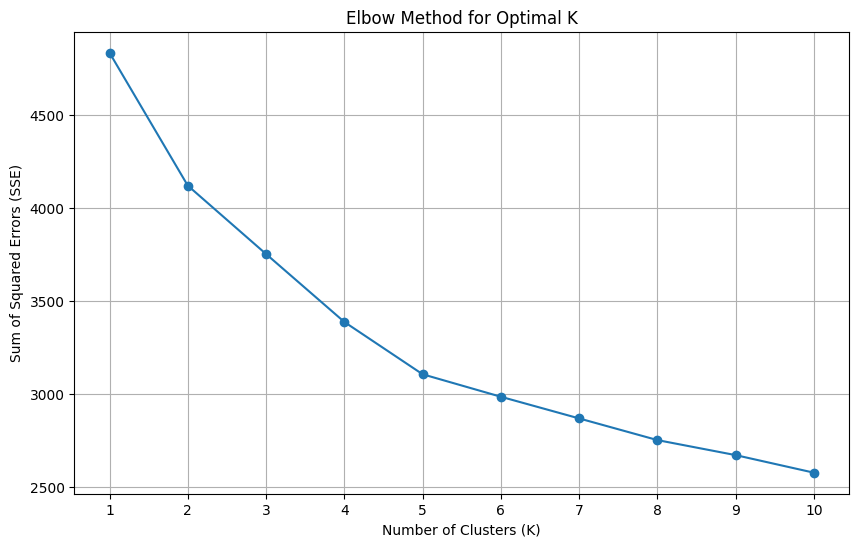

Please examine the Elbow Method plot above to choose an optimal 'k'.
Look for the 'elbow' point where the decrease in SSE starts to slow down.


In [5]:
print("\n--- Determining Optimal K (Elbow Method) ---")
sse = [] # Sum of squared errors
k_range = range(1, 11) # Test K from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init to suppress warning
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_) # inertia is the sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()
print("Please examine the Elbow Method plot above to choose an optimal 'k'.")
print("Look for the 'elbow' point where the decrease in SSE starts to slow down.")
# For demonstration, let's assume an optimal K (you should choose based on the plot)
OPTIMAL_K = 3 # Example: assuming 3 is a good elbow point from a hypothetical plot

# --- 4. Apply K-Means Clustering ---

In [6]:
print(f"\n--- Applying K-Means Clustering with K = {OPTIMAL_K} ---")
kmeans_model = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['Cluster'] = kmeans_model.fit_predict(X_scaled)
print(f"Clustering complete. {OPTIMAL_K} clusters identified.")
print("\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())


--- Applying K-Means Clustering with K = 3 ---
Clustering complete. 3 clusters identified.

Cluster distribution:
0    153
1    126
2     23
Name: Cluster, dtype: int64


# --- 5. Analyze and Visualize Clusters ---

In [7]:
print("\n--- Analyzing Cluster Characteristics ---")
# Calculate the mean of each feature for each cluster
cluster_means = df.groupby('Cluster')[FEATURES_FOR_CLUSTERING].mean().round(2)
print("\nMean feature values per cluster:")
print(cluster_means)

# You can also look at value counts for categorical features within each cluster
print("\nCategorical feature distribution per cluster:")
for cat_col in [col for col in FEATURES_FOR_CLUSTERING if col not in NUMERICAL_COLS_FOR_IMPUTATION]:
    if cat_col in df.columns:
        print(f"\n--- {cat_col.replace('_', ' ').title()} distribution by Cluster ---")
        print(pd.crosstab(df['Cluster'], df[cat_col], normalize='index').mul(100).round(2))


--- Analyzing Cluster Characteristics ---

Mean feature values per cluster:
           age   sex  trestbps    chol   fbs  restecg  thalach  exang  \
Cluster                                                                 
0        51.73  0.61    128.21  242.42  0.14      0.6   160.52   0.07   
1        57.43  0.75    134.03  253.17  0.15     0.46   135.11   0.67   
2        55.87  0.83    140.87  237.13  0.22     0.39   155.96   0.17   

         oldpeak  slope    ca  thal  cp_0  cp_1  cp_2  cp_3  
Cluster                                                      
0           0.53   1.64  0.42  2.16  0.15  0.31  0.54   0.0  
1           1.60   1.13  1.12  2.52  0.95  0.02  0.03   0.0  
2           1.39   1.26  0.48  2.26   0.0   0.0   0.0   1.0  

Categorical feature distribution per cluster:

--- Sex distribution by Cluster ---
sex          0      1
Cluster              
0        39.22  60.78
1        25.40  74.60
2        17.39  82.61

--- Fbs distribution by Cluster ---
fbs          0  

# --- 5.1. Visualize Clusters using PCA (if more than 2 features) ---


--- Visualizing Clusters (using PCA for dimensionality reduction) ---


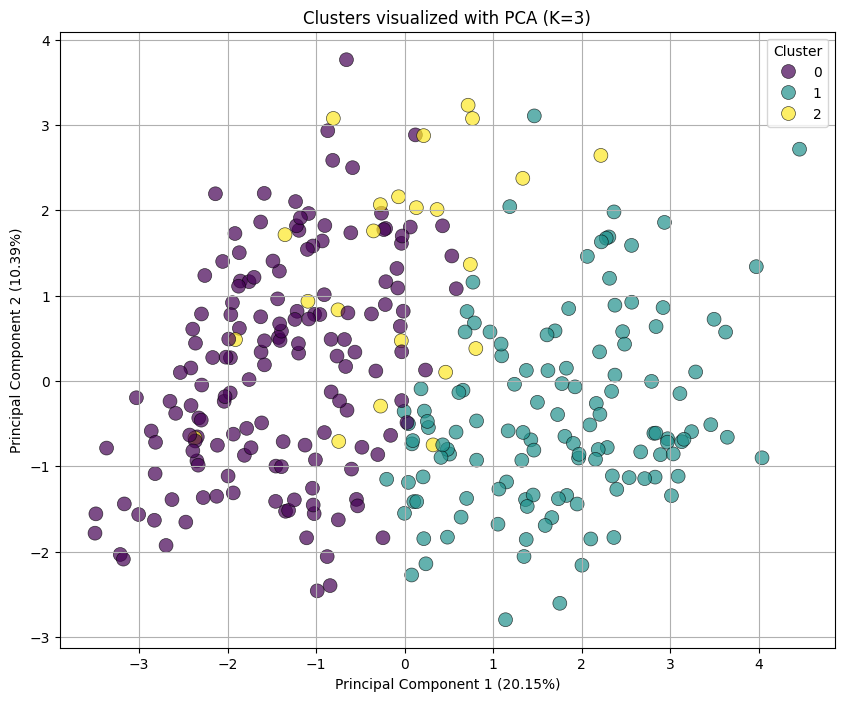

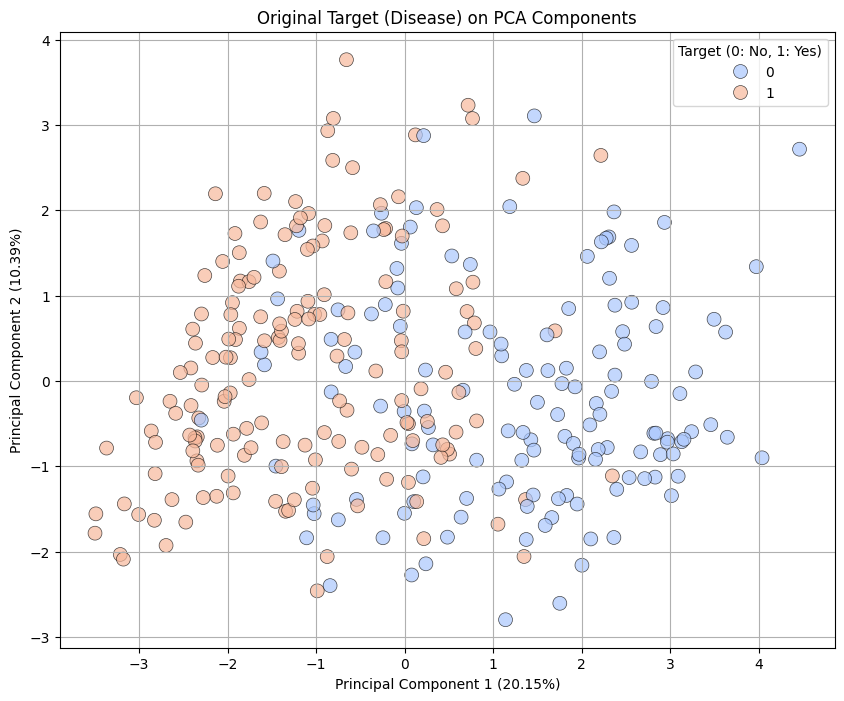

In [8]:
print("\n--- Visualizing Clusters (using PCA for dimensionality reduction) ---")
if len(FEATURES_FOR_CLUSTERING) > 2:
    pca = PCA(n_components=2) # Reduce to 2 principal components for 2D plotting
    principal_components = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = df['Cluster'] # Add cluster labels to the PCA DataFrame
    pca_df['Target'] = df['target'] # Optionally add target for comparison (not used in clustering)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='PC1', y='PC2', hue='Cluster', data=pca_df,
        palette='viridis', s=100, alpha=0.7, ec='black', linewidth=0.5
    )
    plt.title(f'Clusters visualized with PCA (K={OPTIMAL_K})')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # Optional: Visualize clusters colored by the original 'target' variable to see overlap
    if 'target' in df.columns:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x='PC1', y='PC2', hue='Target', data=pca_df,
            palette='coolwarm', s=100, alpha=0.7, ec='black', linewidth=0.5
        )
        plt.title(f'Original Target (Disease) on PCA Components')
        plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
        plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
        plt.legend(title='Target (0: No, 1: Yes)')
        plt.grid(True)
        plt.show()
else:
    print("Skipping PCA visualization as there are 2 or fewer features.")
    # If you have only 2 features, you could plot them directly:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=FEATURES_FOR_CLUSTERING[0], y=FEATURES_FOR_CLUSTERING[1], hue='Cluster', data=df, palette='viridis', s=100)
    plt.title(f'Clusters (K={OPTIMAL_K})')
    plt.show()

In [9]:
print("\nClustering analysis complete.")


Clustering analysis complete.
